<a href="https://colab.research.google.com/github/AIMSS-UAlberta/AI_Models_Lecture_2023/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset**

We aim to solve a **classification** task in this notebook:
The classification question is: Does the person have **pneumonia** or are they **normal** based on their **chest x-ray image**?
The dataset we use for this task and its details can be found at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia .
\
"Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert."


In [ ]:
#Necessary libraries

import os
from google.colab import drive

#math
import numpy as np
import random

#libraries to work with images
import cv2

#plotting
import matplotlib.pyplot as plt 

#metrics for evaluating 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight

#for data generation(when we lack enough data)
from keras.preprocessing.image import ImageDataGenerator

#models
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import MobileNet


In [ ]:
##mount the drive to have access to the dataset on google drive through colab
#you have to download the dataset from kaggle website and put it in your google drive

drive.mount('/content/gdrive')
base_dir = '/content/gdrive/My Drive/AIMSS/chest_xray/' #Then you should write the address to the directory of your dataset here


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#In this cell, we go through the dataset directories and read the name of the image files, and we save the names in lists
train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Nomral images:",len(train_normal+test_normal+val_normal))


Total images: 5860
Total pneumonia images: 4275
Total Nomral images: 1585


In [ ]:
#In this cell, we split the dataset into train, test and validation
#train 80% , test 15%,  validation 5%

pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

train_imgs = pn[:3418]+ normal[:1224]  # 80% of 4273 Pneumonia and normal chest X-ray are 3418 and 1224 respectively.
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[4059:] + normal[1502:]

print("Total train images %s containing %s pneumonia and %s normal images" 
      % (len(train_imgs),len(pn[:3418]),len(normal[:1224])))
print("Total test images %s containing %s pneumonia and %s normal images"
      % (len(test_imgs),len(pn[3418:4059]),len(normal[1224:1502])))
print("Total validation images %s containing %s pneumonia and %s normal images" 
      % (len(val_imgs),len(pn[4059:]),len(normal[1502:])))


#practice: why do we need to shuffle our dataset? When do we need to do it?
random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)


Total train images 4642 containing 3418 pneumonia and 1224 normal images
Total test images 919 containing 641 pneumonia and 278 normal images
Total validation images 299 containing 216 pneumonia and 83 normal images


In [ ]:
#In this cell, we preprocess the images in order to make them ready for being used in the training process

def preprocess_image(image_list):
    X = [] # images
    y = [] #labels (0 for Normal or 1 for Pneumonia)
    count=0
    img_size = 224
    for image in image_list:
        try: #try keyword is to catch errors and not aloow them to throw exceptions
            img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
            img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_CUBIC)
            #convert image to 2D to 3D 
            img = np.dstack([img, img, img])
            #convert greyscale image to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalize Image
            img = img.astype(np.float32)/255.
            count=count+1
            X.append(img)      
        except:
            continue
        if 'PNEUMONIA' in image:
            y.append(1)  
        elif 'NORMAL' in image:
            y.append(0)
    #check images and labels
    unique_vals, unique_counts = np.unique(y, return_counts=True)
    print("label values : " , unique_vals)
    print("occurance: ", unique_counts)
    #change to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

def plot_images(X,y):
  fig = plt.figure(figsize=(20, 5))
  k = 1
  for i in range(4):
      a = fig.add_subplot(1, 4, k)
      if (y[i]==0):
          a.set_title('Normal')
      else:
          a.set_title('Pneumonia')
      plt.imshow(X[i])
      k+=1



label values :  [0 1]
occurance:  [1223 3417]
label values :  [0 1]
occurance:  [278 641]
label values :  [0 1]
occurance:  [ 82 215]


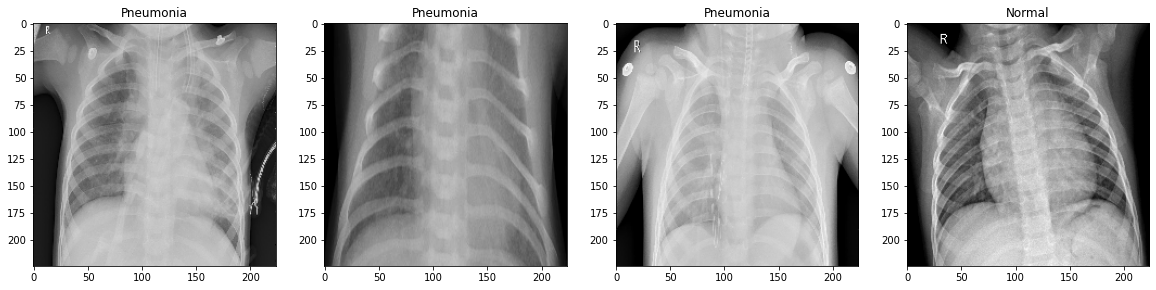

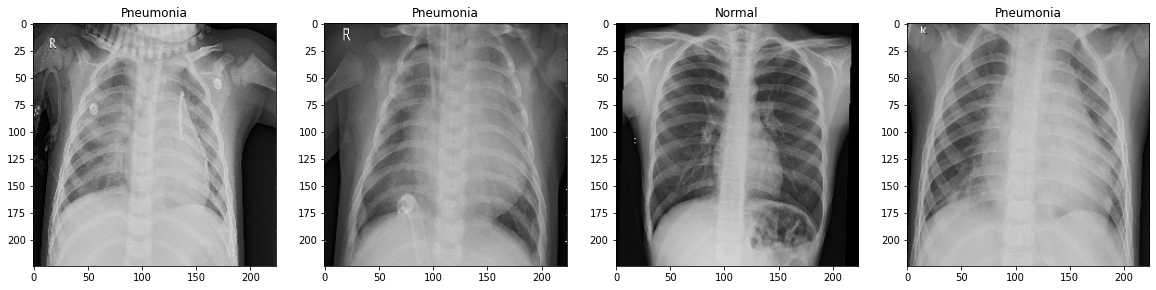

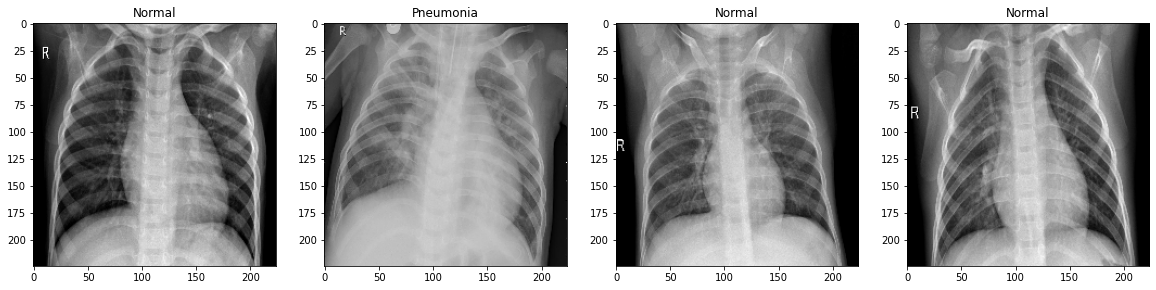

In [ ]:
#in this cell, we preprocess the data, and show some images from the dataset
X_train, y_train = preprocess_image(train_imgs)
plot_images(X_train, y_train)

X_test, y_test = preprocess_image(test_imgs)
plot_images(X_test, y_test)


X_val, y_val = preprocess_image(val_imgs)
plot_images(X_val, y_val)

In [ ]:
#Our dataset is imbalanced, so we need to take care of that using class_weights when training the model
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )                                     
class_weights = dict(enumerate(class_weights))

{0: 1.8969746524938675, 1: 0.6789581504243488}


In [ ]:
#The dataset we have is not very large, therefore we augment the dataset with generated images
#practice: Read about data augmentation. What are the techniques of producing training data when we lack enough data for our tasks?
#our dataset consists of images. How can you make changes to images and generate more data based on them?
train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)
                                   
val_datagen = ImageDataGenerator(zoom_range=0.45) 

#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32) 

# **Convolutional Neural Networks**

In [ ]:
#use a pre-trained model as the base model
base_model = MobileNet(weights=None, include_top=False,input_shape=(224, 224, 3)) 
x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a logistic layer
#practice: Why do we need to add a last layer with sigmoid activation function? (hint: what do we want the output to be?)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile model
#practice: What options are there for the optimizer?(look at the keras documentation and answer this question)
#practice: we chose binary cross entropy as the loss function to optimize, because our task was a binary classification task.
#what if our task was regression? What choices do we have for the loss function for regression and classification tasks? (again, refer to the documentation and the slides.)
model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])


# **Train The Model**

In [ ]:
# We train for 64 epochs 
ntrain = len(X_train)
nval = len(X_val)
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // 32,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // 32,
                              class_weight =class_weights,
)

Epoch 1/64
145/145 [==============================] - 68s 387ms/step - loss: 0.3878 - binary_accuracy: 0.8282 - mae: 0.2142 - val_loss: 1.5202 - val_binary_accuracy: 0.7292 - val_mae: 0.2725
Epoch 2/64
145/145 [==============================] - 53s 367ms/step - loss: 0.2914 - binary_accuracy: 0.8728 - mae: 0.1696 - val_loss: 2.0578 - val_binary_accuracy: 0.7222 - val_mae: 0.2780
Epoch 3/64
145/145 [==============================] - 54s 368ms/step - loss: 0.2540 - binary_accuracy: 0.8901 - mae: 0.1457 - val_loss: 2.7729 - val_binary_accuracy: 0.7153 - val_mae: 0.2847
Epoch 4/64
145/145 [==============================] - 55s 380ms/step - loss: 0.2496 - binary_accuracy: 0.8920 - mae: 0.1431 - val_loss: 2.1133 - val_binary_accuracy: 0.7188 - val_mae: 0.2815
Epoch 5/64
145/145 [==============================] - 67s 458ms/step - loss: 0.2262 - binary_accuracy: 0.9078 - mae: 0.1262 - val_loss: 0.4009 - val_binary_accuracy: 0.8576 - val_mae: 0.1825
Epoch 6/64
145/145 [=========================

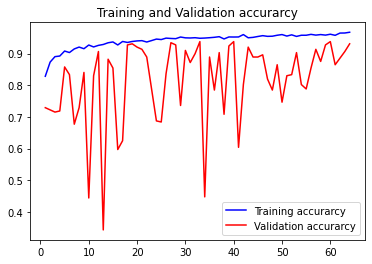

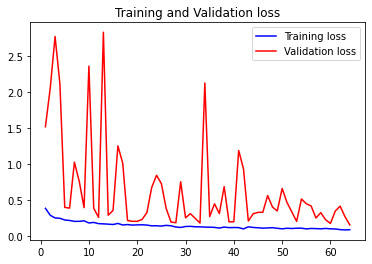

In [ ]:
# Lets plot the train and validation accuracy and loss curve
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# **Test The Model**

In [ ]:
#we use the test data for testing (unseen data)
#practice: Why do you think we seperate train and test data? How can we compare a model in train phase and test phase?
#what about validation data? share your thoughts and feel free to use resources on the internet
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

29/29 [==============================] - 2s 51ms/step

============TEST METRICS=============
Accuracy: 86.8335146898803%
Precision: 94.98269896193771%
Recall: 85.64742589703587%
F1-score: 90.07383100902378

TRAIN METRIC ----------------------
Train acc: 96.7


# **References**

Some links I used for preparing this notebook
https://www.kaggle.com/code/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia/data

https://www.kaggle.com/code/khanfashee/medical-image-classification-for-beginner
